In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from numpy import array
from numpy import diag
from numpy import dot
from scipy.linalg import svd

In [6]:
from surprise import KNNWithMeans
from surprise import Dataset
from surprise import accuracy
from collections import defaultdict
from surprise.model_selection import train_test_split

In [7]:
import sklearn.metrics as metrics
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics.pairwise import pairwise_distances
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns
from sklearn.model_selection import train_test_split
import time
from sklearn.externals import joblib
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer

from datetime import datetime

In [8]:
shopping_df = pd.read_csv('ratings_Electronics.csv',names=['userId','productId', 'Rating','timestamp'])

In [9]:
shopping_df.head()

,userId,productId,Rating,timestamp
0,AKM1MP6P0OYPR,0132793040,5.0,1365811200
1,A2CX7LUOHB2NDG,0321732944,5.0,1341100800
2,A2NWSAGRHCP8N5,0439886341,1.0,1367193600
3,A2WNBOD3WNDNKT,0439886341,3.0,1374451200
4,A1GI0U4ZRJA8WN,0439886341,1.0,1334707200


In [10]:
shopping_df.shape

(7824482, 4)

### There are large number of rows. We could take a smaller subset

In [21]:
shopping_df.dtypes

userId        object
productId     object
Rating       float64
timestamp      int64
dtype: object

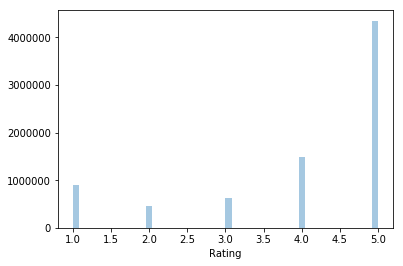

In [11]:
ratings=shopping_df['Rating'].dropna()
sns.distplot(ratings, kde=False)         
plt.show()

In [12]:
shopping_df.groupby('productId')['Rating'].mean().sort_values(ascending=False).head() 

productId
BT008V9J9U    5.0
B0058PPK8Y    5.0
B0058OQ9Q2    5.0
B0058OKSMS    5.0
B0058OHGX2    5.0
Name: Rating, dtype: float64

In [13]:
shopping_df.groupby('productId')['Rating'].count().sort_values(ascending=False).head()  

productId
B0074BW614    18244
B00DR0PDNE    16454
B007WTAJTO    14172
B0019EHU8G    12285
B006GWO5WK    12226
Name: Rating, dtype: int64

In [14]:
ratings_mean_count = pd.DataFrame(shopping_df.groupby('productId')['Rating'].mean()) 
ratings_mean_count['rating_counts'] = pd.DataFrame(shopping_df.groupby('productId')['Rating'].count())  
ratings_mean_count.head()  

,Rating,rating_counts
productId,,
0132793040,5.000000,1
0321732944,5.000000,1
0439886341,1.666667,3
0511189877,4.500000,6
0528881469,2.851852,27


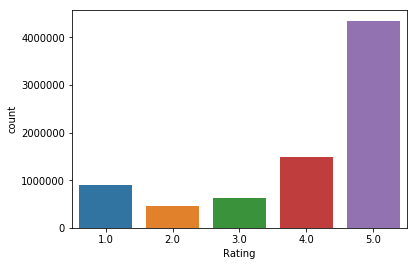

In [15]:
sns.countplot(data=shopping_df , x='Rating')
plt.show()

## 2. Take a subset of the dataset to make it less sparse/ denser.
## ( For example, keep the users only who has given 50 or more number of ratings )

In [20]:
counts1 = shopping_df['userId'].value_counts()
small_df = shopping_df[shopping_df['userId'].isin(counts1[counts1 >= 50].index)]

In [26]:
print('Number of users who have rated 50 or more items =', len(small_df))
print('Number of unique users in the final data = ', small_df['userId'].nunique())
print('Number of unique products in the final data = ', small_df['productId'].nunique())

Number of users who have rated 50 or more items = 125871
Number of unique users in the final data =  1540
Number of unique products in the final data =  48190


### ratings analysis in smaller dataset

In [27]:
ratings_matrix = small_df.pivot(index='userId', columns='productId', values='Rating').fillna(0)
userId = ratings_matrix.index
productId = ratings_matrix.columns
print(ratings_matrix.shape)
ratings_matrix.head()

(1540, 48190)


productId,0594451647,0594481813,0970407998,0972683275,1400501466,1400501520,1400501776,1400532620,1400532655,140053271X,...,B00L5YZCCG,B00L8I6SFY,B00L8QCVL6,B00LA6T0LS,B00LBZ1Z7K,B00LED02VY,B00LGN7Y3G,B00LGQ6HL8,B00LI4ZZO8,B00LKG1MC8
userId,,,,,,,,,,,,,,,,,,,,,
A100UD67AHFODS,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A100WO06OQR8BQ,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A105S56ODHGJEK,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A105TOJ6LTVMBG,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A10AFVU66A79Y1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [28]:
print('Shape of final_ratings_matrix: ', ratings_matrix.shape)

Shape of final_ratings_matrix:  (1540, 48190)


In [29]:
#Find the density of the marix
ratings_given = np.count_nonzero(ratings_matrix)
print('given_num_of_ratings = ', ratings_given)
possible_num_of_ratings = ratings_matrix.shape[0] * ratings_matrix.shape[1]
print('possible_num_of_ratings = ', possible_num_of_ratings)
density = (ratings_given/possible_num_of_ratings)
density *= 100
print ('density: {:4.2f}%'.format(density))

given_num_of_ratings =  125871
possible_num_of_ratings =  74212600
density: 0.17%


## Extremely Sparse Matrix

## 3. Split the data randomly into train and test dataset. ( For
## example, split it in 70/30 ratio)

In [24]:
#Split the data randomnly into train and test datasets into 70:30 ratio
train_data, test_data = train_test_split(small_df, test_size = 0.3, random_state=0)
train_data.head()

,userId,productId,Rating,timestamp
6595853,A2BYV7S1QP2YIG,B009EAHVTA,5.0,1399161600
4738241,AB094YABX21WQ,B0056XCEAA,1.0,1315267200
4175596,A3D0UM4ZD2CMAW,B004I763AW,5.0,1355616000
3753016,AATWFX0ZZSE6C,B0040NPHMO,3.0,1293753600
1734767,A1NNMOD9H36Q8E,B0015VW3BM,4.0,1220313600


## 5. Building Popularity Recommder model

In [31]:
#Count of user_id for each unique product as recommendation score 
train_data_grouped = train_data.groupby('productId').agg({'userId': 'count'}).reset_index()
train_data_grouped.rename(columns = {'userId': 'count_of_users'},inplace=True)
train_data_grouped.head()

,productId,count_of_users
0,0594451647,1
1,0594481813,1
2,0970407998,1
3,0972683275,3
4,1400501466,4


In [34]:
#Sort the products on recommendation score 
train_data_sort = train_data_grouped.sort_values(['count_of_users', 'productId'], ascending = [0,1]) 
      
#Generate a recommendation rank based upon score 
train_data_sort['rank'] = train_data_sort['count_of_users'].rank(ascending=0, method='first') 
          
#Get the top 5 recommendations 
popularity_recommendations = train_data_sort.head(5) 
popularity_recommendations

,productId,count_of_users,rank
30847,B0088CJT4U,133,1.0
30287,B007WTAJTO,124,2.0
19647,B003ES5ZUU,122,3.0
8752,B000N99BBC,114,4.0
30555,B00829THK0,97,5.0


In [35]:
# Use popularity based recommender model to make predictions
def recommend(user_id):     
    user_recommendations = popularity_recommendations 
          
    #Add user_id column for which the recommendations are being generated 
    user_recommendations['userId'] = user_id 
      
    #Bring user_id column to the front 
    cols = user_recommendations.columns.tolist() 
    cols = cols[-1:] + cols[:-1] 
    user_recommendations = user_recommendations[cols] 
          
    return user_recommendations

In [36]:
find_recom = [1,100,1500]   # This list is user choice.
for i in find_recom:
    print("The list of recommendations for the userId: %d\n" %(i))
    print(recommend(i))    
    print("\n")

The list of recommendations for the userId: 1

       userId   productId  count_of_users  rank
30847       1  B0088CJT4U             133   1.0
30287       1  B007WTAJTO             124   2.0
19647       1  B003ES5ZUU             122   3.0
8752        1  B000N99BBC             114   4.0
30555       1  B00829THK0              97   5.0


The list of recommendations for the userId: 100

       userId   productId  count_of_users  rank
30847     100  B0088CJT4U             133   1.0
30287     100  B007WTAJTO             124   2.0
19647     100  B003ES5ZUU             122   3.0
8752      100  B000N99BBC             114   4.0
30555     100  B00829THK0              97   5.0


The list of recommendations for the userId: 1500

       userId   productId  count_of_users  rank
30847    1500  B0088CJT4U             133   1.0
30287    1500  B007WTAJTO             124   2.0
19647    1500  B003ES5ZUU             122   3.0
8752     1500  B000N99BBC             114   4.0
30555    1500  B00829THK0         

## Since, it is a Popularity recommender model, so, all the three users are given the same recommendations. Here, we predict the products based on the popularity. It is not personalized to particular user

### Collaborative Filtering Based Recommendation Systems

In [37]:
counts1 = shopping_df['userId'].value_counts()
# print(counts1)
ratings = shopping_df[shopping_df['userId'].isin(counts1[counts1 >= 50].index)]

In [38]:
ratings.head()

,userId,productId,Rating,timestamp
94,A3BY5KCNQZXV5U,0594451647,5.0,1390176000
118,AT09WGFUM934H,0594481813,3.0,1377907200
177,A32HSNCNPRUMTR,0970407998,1.0,1319673600
178,A17HMM1M7T9PJ1,0970407998,4.0,1281744000
492,A3CLWR1UUZT6TG,0972683275,5.0,1373587200


In [39]:
ratings_matrix = ratings.pivot(index='userId', columns='productId', values='Rating').fillna(0)
userId = ratings_matrix.index
productId = ratings_matrix.columns
print(ratings_matrix.shape)
ratings_matrix.head()

(1540, 48190)


productId,0594451647,0594481813,0970407998,0972683275,1400501466,1400501520,1400501776,1400532620,1400532655,140053271X,...,B00L5YZCCG,B00L8I6SFY,B00L8QCVL6,B00LA6T0LS,B00LBZ1Z7K,B00LED02VY,B00LGN7Y3G,B00LGQ6HL8,B00LI4ZZO8,B00LKG1MC8
userId,,,,,,,,,,,,,,,,,,,,,
A100UD67AHFODS,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A100WO06OQR8BQ,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A105S56ODHGJEK,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A105TOJ6LTVMBG,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A10AFVU66A79Y1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### We know this is a sparse matrix, so  we will use SVD.

In [43]:
from scipy.sparse.linalg import svds
U, sigma, Vt = svds(ratings_matrix, k = 50)

In [44]:
sigma = np.diag(sigma)
all_user_predicted_ratings = np.dot(np.dot(U, sigma), Vt) 
preds_df = pd.DataFrame(all_user_predicted_ratings, columns = ratings_matrix.columns)

In [45]:
preds_df.head()

productId,0594451647,0594481813,0970407998,0972683275,1400501466,1400501520,1400501776,1400532620,1400532655,140053271X,...,B00L5YZCCG,B00L8I6SFY,B00L8QCVL6,B00LA6T0LS,B00LBZ1Z7K,B00LED02VY,B00LGN7Y3G,B00LGQ6HL8,B00LI4ZZO8,B00LKG1MC8
0,0.005086,0.002178,0.003668,-0.040843,0.009640,0.006808,0.020659,0.000649,0.020331,0.005633,...,0.000238,-0.061477,0.001214,-0.123433,0.028490,0.016109,0.002855,-0.174568,0.011367,-0.012997
1,0.002286,-0.010898,-0.000724,0.130259,0.007506,-0.003350,0.063711,-0.000674,0.016111,-0.002433,...,-0.000038,0.013766,0.001473,0.025588,-0.042103,0.004251,0.002177,-0.024362,-0.014765,0.038570
2,-0.001655,-0.002675,-0.007355,0.007264,0.005152,-0.003986,-0.003480,0.006961,-0.006606,-0.002719,...,-0.001708,-0.051040,0.000325,-0.054867,0.017870,-0.004996,-0.002426,0.083928,-0.112205,0.005964
3,0.001856,0.011019,-0.005910,-0.014134,0.000179,0.001877,-0.005391,-0.001709,0.004968,0.001402,...,0.000582,-0.009326,-0.000465,-0.048315,0.023302,0.006790,0.003380,0.005460,-0.015263,-0.025996
4,0.001115,-0.002670,0.011018,0.014434,0.010319,0.006002,0.017151,0.003726,0.001404,0.005645,...,0.000207,0.023761,0.000747,-0.019347,-0.012749,0.001026,0.001364,-0.020580,0.011828,0.012770


In [51]:
# Recommend the items with the highest predicted ratings

def recommend_items(userID, pivot_df, preds_df, num_recommendations):
    # index starts at 0  
    user_idx = userID-1 
    # Get and sort the user's ratings
    sorted_user_ratings = pivot_df.iloc[user_idx].sort_values(ascending=False)
    #sorted_user_ratings
    sorted_user_predictions = preds_df.iloc[user_idx].sort_values(ascending=False)
    #sorted_user_predictions
    temp = pd.concat([sorted_user_ratings, sorted_user_predictions], axis=1)
    temp.index.name = 'Recommended Items'
    temp.columns = ['user_ratings', 'user_predictions']
    temp = temp.loc[temp.user_ratings == 0]   
    temp = temp.sort_values('user_predictions', ascending=False)
    print('\nBelow are the recommended items for user(user_id = {}):\n'.format(userID))
    print(temp.head(num_recommendations))

In [68]:
user_id = 1

In [69]:
userID = ratings_matrix.iloc[user_id-1, :].name
userID

'A100UD67AHFODS'

In [70]:
num_recommendations = 5
recommend_items(user_id, ratings_matrix, preds_df, num_recommendations)


Below are the recommended items for user(user_id = 1):

                   user_ratings  user_predictions
Recommended Items                                
B0019EHU8G                  0.0          1.407411
B003ES5ZUU                  0.0          1.097482
B007OY5V68                  0.0          0.987353
B000JMJWV2                  0.0          0.946122
B009SYZ8OC                  0.0          0.847875


In [71]:
user_id = 100

In [72]:
num_recommendations = 5
recommend_items(user_id, ratings_matrix, preds_df, num_recommendations)


Below are the recommended items for user(user_id = 100):

                   user_ratings  user_predictions
Recommended Items                                
B000QUUFRW                  0.0          0.707524
B002V88HFE                  0.0          0.646016
B007WTAJTO                  0.0          0.580565
B002WE6D44                  0.0          0.487400
B000AZ57M6                  0.0          0.484131


In [73]:
user_id = 1500

In [74]:
num_recommendations = 5
recommend_items(user_id, ratings_matrix, preds_df, num_recommendations)


Below are the recommended items for user(user_id = 1500):

                   user_ratings  user_predictions
Recommended Items                                
B00834SJNA                  0.0          1.140105
B008DWCRQW                  0.0          1.054701
B007WTAJTO                  0.0          0.899305
B000QUUFRW                  0.0          0.897270
B0000BZL1P                  0.0          0.676210


## Since, it is a Collaborative recommender model, so, all the three users are given different recommendations based on users past behaviour

## 7. Evaluation of Collabrative recommendation model

In [59]:
ratings_matrix.head()

productId,0594451647,0594481813,0970407998,0972683275,1400501466,1400501520,1400501776,1400532620,1400532655,140053271X,...,B00L5YZCCG,B00L8I6SFY,B00L8QCVL6,B00LA6T0LS,B00LBZ1Z7K,B00LED02VY,B00LGN7Y3G,B00LGQ6HL8,B00LI4ZZO8,B00LKG1MC8
userId,,,,,,,,,,,,,,,,,,,,,
A100UD67AHFODS,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A100WO06OQR8BQ,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A105S56ODHGJEK,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A105TOJ6LTVMBG,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A10AFVU66A79Y1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [60]:
ratings_matrix.mean().head()

productId
0594451647    0.003247
0594481813    0.001948
0970407998    0.003247
0972683275    0.012338
1400501466    0.012987
dtype: float64

In [61]:
preds_df.head()

productId,0594451647,0594481813,0970407998,0972683275,1400501466,1400501520,1400501776,1400532620,1400532655,140053271X,...,B00L5YZCCG,B00L8I6SFY,B00L8QCVL6,B00LA6T0LS,B00LBZ1Z7K,B00LED02VY,B00LGN7Y3G,B00LGQ6HL8,B00LI4ZZO8,B00LKG1MC8
0,0.005086,0.002178,0.003668,-0.040843,0.009640,0.006808,0.020659,0.000649,0.020331,0.005633,...,0.000238,-0.061477,0.001214,-0.123433,0.028490,0.016109,0.002855,-0.174568,0.011367,-0.012997
1,0.002286,-0.010898,-0.000724,0.130259,0.007506,-0.003350,0.063711,-0.000674,0.016111,-0.002433,...,-0.000038,0.013766,0.001473,0.025588,-0.042103,0.004251,0.002177,-0.024362,-0.014765,0.038570
2,-0.001655,-0.002675,-0.007355,0.007264,0.005152,-0.003986,-0.003480,0.006961,-0.006606,-0.002719,...,-0.001708,-0.051040,0.000325,-0.054867,0.017870,-0.004996,-0.002426,0.083928,-0.112205,0.005964
3,0.001856,0.011019,-0.005910,-0.014134,0.000179,0.001877,-0.005391,-0.001709,0.004968,0.001402,...,0.000582,-0.009326,-0.000465,-0.048315,0.023302,0.006790,0.003380,0.005460,-0.015263,-0.025996
4,0.001115,-0.002670,0.011018,0.014434,0.010319,0.006002,0.017151,0.003726,0.001404,0.005645,...,0.000207,0.023761,0.000747,-0.019347,-0.012749,0.001026,0.001364,-0.020580,0.011828,0.012770


In [62]:
preds_df.mean().head()

productId
0594451647    0.001953
0594481813    0.002875
0970407998    0.003355
0972683275    0.010343
1400501466    0.004871
dtype: float64

In [63]:
rmse_df = pd.concat([ratings_matrix.mean(), preds_df.mean()], axis=1)
rmse_df.columns = ['Avg_actual_ratings', 'Avg_predicted_ratings']
print(rmse_df.shape)
rmse_df['item_index'] = np.arange(0, rmse_df.shape[0], 1)
rmse_df.head()

(48190, 2)


,Avg_actual_ratings,Avg_predicted_ratings,item_index
productId,,,
0594451647,0.003247,0.001953,0
0594481813,0.001948,0.002875,1
0970407998,0.003247,0.003355,2
0972683275,0.012338,0.010343,3
1400501466,0.012987,0.004871,4


In [64]:
RMSE = round((((rmse_df.Avg_actual_ratings - rmse_df.Avg_predicted_ratings) ** 2).mean() ** 0.5), 5)
print('\nRMSE SVD Model = {} \n'.format(RMSE))



RMSE SVD Model = 0.00275 



## 8. Getting top - K ( K = 5) recommendations

In [67]:
# Enter 'user_Id' and 'num_recommendations' for the user #
user_id = 40
num_recommendations = 5
recommend_items(user_id, ratings_matrix, preds_df, num_recommendations)


Below are the recommended items for user(user_id = 40):

                   user_ratings  user_predictions
Recommended Items                                
B0041Q38NU                  0.0          0.388290
B000LRMS66                  0.0          0.381645
B00DVFLJDS                  0.0          0.375487
B000JE7GPY                  0.0          0.360242
B000JMJWV2                  0.0          0.319584


## 9. Final Insights

### The Popularity-based recommender system is a non-personalised recommender system and these are based on frequecy counts, which may be not suitable to the user.We can see the differance above for the user id 1, 100 & 1500, The Popularity based model has recommended the same set of 5 products to both but Collaborative Filtering based model has recommended entire different list based on the user past purchase history.

### Model-based Collaborative Filtering is a personalised recommender system, the recommendations are based on the past behavior of the user and it is not dependent on any additional information